In [1]:
import os
from random import shuffle
from pprint import pprint
from ast import literal_eval
from tqdm import trange, tqdm
import numpy as np

import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
from sklearn.metrics import f1_score, classification_report

from models.net_keras import simple_cnn_keras
from data_loader.data_loader import fix_save_case_partition, load_patches
from utils import get_config_sha1
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, AveragePooling2D
from matplotlib.pyplot import imshow
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Conv2D, Dropout, SeparableConv2D
from keras.layers import Softmax, Concatenate
from data_loader.preprocessing import minmax_normalization, windowing, smoothing
from skimage import morphology, measure
import itertools

Using TensorFlow backend.


In [2]:
with open('./configs/config_tinghui.txt', 'r') as f:
    config = literal_eval(f.read())
    config['config_sha1'] = get_config_sha1(config, 5)
    pprint(config)

{'CUDA_VISIBLE_DEVICES': '0',
 'GPU_memory_fraction': 0.5,
 'batch_size': 32,
 'case_list_dir': '/home/d/pancreas/box_data',
 'case_partition_path': '',
 'case_split_ratio': (0.8, 0.1, 0.1),
 'config_sha1': 'd10ec',
 'conv1_dim': 64,
 'epochs': 200,
 'input_dim': (50, 50, 1),
 'lr': 0.0001,
 'model': 'simple_cnn_sigmoid_keras',
 'num_cpu': 10,
 'patch_lesion_dir': '/home/d/pancreas/patch_data/withmask/lesion',
 'patch_pancreas_dir': '/home/d/pancreas/patch_data/withmask/pancreas',
 'random_seed': 13,
 'val_batch_size': 512}


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

set_session(tf.Session(config=sess_config))

In [4]:
from data_loader.data_loader import convert_csv_to_dict
case_partition = convert_csv_to_dict('/home/d/pancreas/raw_data/data_list.csv')

Finish converting csv to dict


In [5]:
patch_size = (50, 50, 1)
stride = (25, 25, 1)
target_size = (50, 50, 1)

In [6]:
case_partition.keys()

dict_keys(['train', 'validation', 'test', 'all'])

In [7]:
import heatmap
_, train_list, train_mask = heatmap.load_slices(config['case_list_dir'], case_partition['train'])
_, test_list, test_mask = heatmap.load_slices(config['case_list_dir'], case_partition['test'])
_, validation_list, validation_mask = heatmap.load_slices(config['case_list_dir'], case_partition['validation'])

In [8]:
import dataloader
loader = dataloader.dataloder(patch_size, stride, target_size)

In [9]:
train_X, train_Y = loader.construct(train_list, train_mask)
validation_X, validation_Y = loader.construct(validation_list, validation_mask)
test_X, test_Y = loader.construct(test_list, test_mask)

In [10]:
# imshow(train_X[199736, 10:20, 10:20, 1])

In [11]:
# np.sum(train_X[199736, 10:20, 10:20, 1:1])

In [12]:
train_bg = loader.verify_background(train_X)
test_bg = loader.verify_background(test_X)
validation_bg = loader.verify_background(validation_X)

In [13]:
print('Include Background')
print('train contain lesion: {}, no: {}'.format(np.sum(train_Y == 1), np.sum(train_Y == 0)))
print('valid contain lesion: {}, no: {}'.format(np.sum(validation_Y == 1), np.sum(validation_Y == 0)))
print('test  contain lesion: {}, no: {}'.format(np.sum(test_Y == 1), np.sum(test_Y == 0)))
print('Do Not Include Background')
print('train contain lesion: {}, no: {}'.format(np.sum(train_Y[~train_bg] == 1), np.sum(train_Y[~train_bg] == 0)))
print('valid contain lesion: {}, no: {}'.format(np.sum(validation_Y[~validation_bg] == 1), np.sum(validation_Y[~validation_bg] == 0)))
print('test  contain lesion: {}, no: {}'.format(np.sum(test_Y[~test_bg] == 1), np.sum(test_Y[~test_bg] == 0)))

Include Background
train contain lesion: 7481, no: 221345
valid contain lesion: 2379, no: 69129
test  contain lesion: 1396, no: 76095
Do Not Include Background
train contain lesion: 7481, no: 23114
valid contain lesion: 2379, no: 7395
test  contain lesion: 1392, no: 8554


In [14]:
# def normalize(img_list):
    
#     std = np.std(img_list, axis=(1, 2, 3), keepdims=True)
#     mean = np.mean(img_list, axis=(1, 2, 3), keepdims=True)
#     print(std.shape, mean.shape)
#     return (img_list - mean)/std

In [15]:
# normal_train_X = train_X
# normal_train_X[~train_bg] = normalize(normal_train_X[~train_bg])
# normal_validation_X = validation_X
# normal_validation_X[~validation_bg] = normalize(normal_validation_X[~validation_bg])
# normal_test_X = test_X
# normal_test_X[~test_bg] = normalize(normal_test_X[~test_bg])

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True, fill_mode='constant', cval=0.0, vertical_flip=True)
datagen.fit(train_X[~train_bg])

In [17]:
from models.net_keras import simple_cnn_sigmoid_keras
model = simple_cnn_sigmoid_keras(patch_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [18]:
# def simple_cnn(input_shape):
#     model = Sequential()
#     model.add(SeparableConv2D(8, kernel_size=(5, 5), activation='relu', 
#                      input_shape=input_shape, padding='same'))
#     model.add(SeparableConv2D(16, (5, 5), activation='relu', padding='same'))
#     model.add(AveragePooling2D(pool_size=(2, 2)))
#     model.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(AveragePooling2D(pool_size=(3, 3)))
#     model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(SeparableConv2D(64, (5, 5), activation='relu'))
#     model.add(Flatten())
# #     model.add(Dense(32, activation='relu'))
# #     model.add(Dropout(0.25))
# #     model.add(Dense(32, activation='relu'))
    
#     model.add(Dense(1, activation='sigmoid'))

#     return model

In [19]:
# model = simple_cnn(patch_size)
# model.summary()

In [20]:
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(amsgrad=True),
    metrics=['accuracy'])
cbs = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
    keras.callbacks.ModelCheckpoint('model0313.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
]

history = model.fit_generator(
    datagen.flow(train_X[~train_bg], train_Y[~train_bg], batch_size=2560),
    epochs=200,
    callbacks=cbs,
    steps_per_epoch=len(train_X[~train_bg]) / 2560,
    class_weight='auto',
    validation_data=(validation_X[~validation_bg], validation_Y[~validation_bg]))

Epoch 1/200
12/11 [==============================] - 10s 812ms/step - loss: 0.5968 - acc: 0.7479 - val_loss: 0.5131 - val_acc: 0.7566
Epoch 2/200
12/11 [==============================] - 3s 276ms/step - loss: 0.5206 - acc: 0.7555 - val_loss: 0.5066 - val_acc: 0.7566
Epoch 3/200
12/11 [==============================] - 3s 236ms/step - loss: 0.5030 - acc: 0.7554 - val_loss: 0.4911 - val_acc: 0.7566
Epoch 4/200
12/11 [==============================] - 3s 236ms/step - loss: 0.4781 - acc: 0.7555 - val_loss: 0.4781 - val_acc: 0.7566
Epoch 5/200
12/11 [==============================] - 3s 238ms/step - loss: 0.4541 - acc: 0.7555 - val_loss: 0.4424 - val_acc: 0.7566
Epoch 6/200
12/11 [==============================] - 3s 235ms/step - loss: 0.4482 - acc: 0.7977 - val_loss: 0.5046 - val_acc: 0.7843
Epoch 7/200
12/11 [==============================] - 3s 235ms/step - loss: 0.4514 - acc: 0.7945 - val_loss: 0.4384 - val_acc: 0.8011
Epoch 8/200
12/11 [==============================] - 3s 235ms/step -

12/11 [==============================] - 3s 234ms/step - loss: 0.2906 - acc: 0.8752 - val_loss: 0.2941 - val_acc: 0.8830
Epoch 63/200
12/11 [==============================] - 3s 233ms/step - loss: 0.2885 - acc: 0.8767 - val_loss: 0.2824 - val_acc: 0.8877
Epoch 64/200
12/11 [==============================] - 3s 234ms/step - loss: 0.2883 - acc: 0.8763 - val_loss: 0.2784 - val_acc: 0.8866
Epoch 65/200
12/11 [==============================] - 3s 233ms/step - loss: 0.2900 - acc: 0.8754 - val_loss: 0.2796 - val_acc: 0.8806
Epoch 66/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2870 - acc: 0.8753 - val_loss: 0.3008 - val_acc: 0.8724
Epoch 67/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2851 - acc: 0.8779 - val_loss: 0.2983 - val_acc: 0.8710
Epoch 68/200
12/11 [==============================] - 3s 233ms/step - loss: 0.2797 - acc: 0.8806 - val_loss: 0.2852 - val_acc: 0.8801
Epoch 69/200
12/11 [==============================] - 3s 234ms/step - loss:

Epoch 122/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2173 - acc: 0.9122 - val_loss: 0.2588 - val_acc: 0.8879
Epoch 123/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2162 - acc: 0.9115 - val_loss: 0.2583 - val_acc: 0.8881
Epoch 124/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2187 - acc: 0.9114 - val_loss: 0.2580 - val_acc: 0.8878
Epoch 125/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2175 - acc: 0.9120 - val_loss: 0.2583 - val_acc: 0.8880
Epoch 126/200
12/11 [==============================] - 3s 234ms/step - loss: 0.2189 - acc: 0.9113 - val_loss: 0.2582 - val_acc: 0.8884
Epoch 127/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2177 - acc: 0.9117 - val_loss: 0.2584 - val_acc: 0.8886
Epoch 128/200
12/11 [==============================] - 3s 234ms/step - loss: 0.2190 - acc: 0.9112 - val_loss: 0.2583 - val_acc: 0.8884
Epoch 129/200
12/11 [==============================] - 

In [21]:
loss, acc = model.evaluate(test_X[~test_bg], test_Y[~test_bg])
print('loss = ', loss, 'acc = ', acc)

9946/9946 [==============================] - 1s 108us/step
loss =  0.2889930904538246 acc =  0.8710034184956392


In [22]:
pd = model.predict_classes(test_X[~test_bg])

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pd, test_Y[~test_bg])

array([[7744,  473],
       [ 810,  919]])

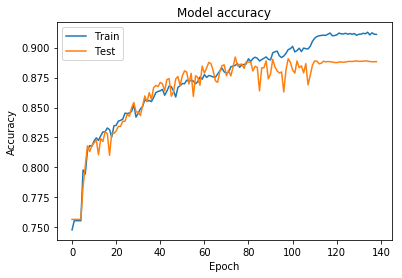

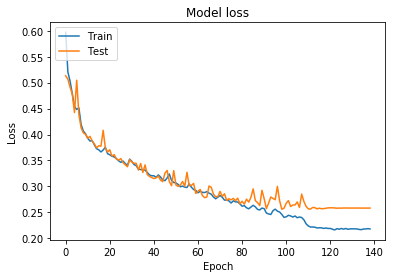

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
model2 = simple_cnn_sigmoid_keras(patch_size)
model2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(amsgrad=True),
    metrics=['accuracy'])
cbs = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
    keras.callbacks.ModelCheckpoint('model20313.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
]

history = model2.fit_generator(
    datagen.flow(train_X[~train_bg], train_Y[~train_bg], batch_size=2560),
    epochs=200,
    callbacks=cbs,
    steps_per_epoch=len(train_X[~train_bg]) / 2560,
    validation_data=(validation_X[~validation_bg], validation_Y[~validation_bg]))

Epoch 1/200
12/11 [==============================] - 4s 300ms/step - loss: 0.6164 - acc: 0.7179 - val_loss: 0.5398 - val_acc: 0.7566
Epoch 2/200
12/11 [==============================] - 3s 236ms/step - loss: 0.5287 - acc: 0.7555 - val_loss: 0.5165 - val_acc: 0.7566
Epoch 3/200
12/11 [==============================] - 3s 237ms/step - loss: 0.5141 - acc: 0.7555 - val_loss: 0.5014 - val_acc: 0.7566
Epoch 4/200
12/11 [==============================] - 3s 236ms/step - loss: 0.4983 - acc: 0.7554 - val_loss: 0.4857 - val_acc: 0.7566
Epoch 5/200
12/11 [==============================] - 3s 236ms/step - loss: 0.4736 - acc: 0.7555 - val_loss: 0.4625 - val_acc: 0.7566
Epoch 6/200
12/11 [==============================] - 3s 234ms/step - loss: 0.4461 - acc: 0.7554 - val_loss: 0.4387 - val_acc: 0.7566
Epoch 7/200
12/11 [==============================] - 3s 236ms/step - loss: 0.4213 - acc: 0.7929 - val_loss: 0.4425 - val_acc: 0.8172
Epoch 8/200
12/11 [==============================] - 3s 234ms/step - 

12/11 [==============================] - 3s 235ms/step - loss: 0.2871 - acc: 0.8757 - val_loss: 0.2911 - val_acc: 0.8751
Epoch 63/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2843 - acc: 0.8761 - val_loss: 0.2930 - val_acc: 0.8742
Epoch 64/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2827 - acc: 0.8772 - val_loss: 0.2814 - val_acc: 0.8788
Epoch 65/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2823 - acc: 0.8791 - val_loss: 0.2932 - val_acc: 0.8743
Epoch 66/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2837 - acc: 0.8770 - val_loss: 0.2873 - val_acc: 0.8769
Epoch 67/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2850 - acc: 0.8744 - val_loss: 0.2897 - val_acc: 0.8746
Epoch 68/200
12/11 [==============================] - 3s 235ms/step - loss: 0.2775 - acc: 0.8794 - val_loss: 0.2818 - val_acc: 0.8771
Epoch 69/200
12/11 [==============================] - 3s 236ms/step - loss:

12/11 [==============================] - 3s 235ms/step - loss: 0.2214 - acc: 0.9099 - val_loss: 0.2566 - val_acc: 0.8897
Epoch 122/200
12/11 [==============================] - 3s 229ms/step - loss: 0.2214 - acc: 0.9100 - val_loss: 0.2565 - val_acc: 0.8896
Epoch 123/200
12/11 [==============================] - 3s 237ms/step - loss: 0.2240 - acc: 0.9082 - val_loss: 0.2565 - val_acc: 0.8898
Epoch 124/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2229 - acc: 0.9086 - val_loss: 0.2565 - val_acc: 0.8897
Epoch 125/200
12/11 [==============================] - 3s 237ms/step - loss: 0.2202 - acc: 0.9103 - val_loss: 0.2565 - val_acc: 0.8896
Epoch 126/200
12/11 [==============================] - 3s 228ms/step - loss: 0.2217 - acc: 0.9092 - val_loss: 0.2565 - val_acc: 0.8896
Epoch 127/200
12/11 [==============================] - 3s 236ms/step - loss: 0.2220 - acc: 0.9100 - val_loss: 0.2565 - val_acc: 0.8896
Epoch 128/200
12/11 [==============================] - 3s 236ms/step 

In [26]:
loss, acc = model2.evaluate(test_X[~test_bg], test_Y[~test_bg])
print('loss = ', loss, 'acc = ', acc)
pd = model2.predict_classes(test_X[~test_bg])
print(confusion_matrix(pd, test_Y[~test_bg]))

9946/9946 [==============================] - 1s 106us/step
loss =  0.2796608455356858 acc =  0.8810577116308859
[[7883  512]
 [ 671  880]]


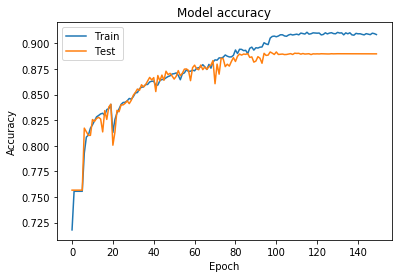

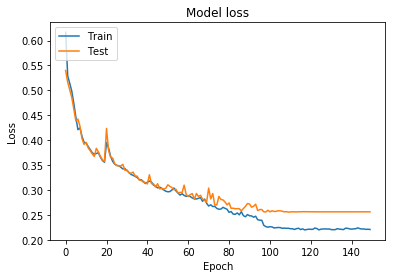

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
weight = np.array([7481, 23114])
weight = weight/np.sum(weight)
print(weight)

[0.24451708 0.75548292]


In [43]:
model3 = simple_cnn_sigmoid_keras(patch_size)
model3.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(amsgrad=True),
    metrics=['accuracy'])
cbs = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=40),
    keras.callbacks.ModelCheckpoint('model30313.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
]

history = model3.fit_generator(
    datagen.flow(train_X[~train_bg], train_Y[~train_bg], batch_size=2560),
    epochs=200,
    callbacks=cbs,
    class_weight=weight_dict,
    steps_per_epoch=len(train_X[~train_bg]) / 2560,
    validation_data=(validation_X[~validation_bg], validation_Y[~validation_bg]))

Epoch 1/200
12/11 [==============================] - 4s 298ms/step - loss: 0.9864 - acc: 0.5424 - val_loss: 0.5052 - val_acc: 0.7962
Epoch 2/200
12/11 [==============================] - 3s 230ms/step - loss: 0.9039 - acc: 0.7393 - val_loss: 0.5476 - val_acc: 0.7589
Epoch 3/200
12/11 [==============================] - 3s 230ms/step - loss: 0.8444 - acc: 0.7484 - val_loss: 0.5112 - val_acc: 0.7785
Epoch 4/200
12/11 [==============================] - 3s 229ms/step - loss: 0.8111 - acc: 0.7536 - val_loss: 0.5253 - val_acc: 0.7447
Epoch 5/200
12/11 [==============================] - 3s 230ms/step - loss: 0.7746 - acc: 0.7617 - val_loss: 0.5461 - val_acc: 0.7256
Epoch 6/200
12/11 [==============================] - 3s 232ms/step - loss: 0.7279 - acc: 0.7651 - val_loss: 0.5805 - val_acc: 0.6924
Epoch 7/200
12/11 [==============================] - 3s 230ms/step - loss: 0.7055 - acc: 0.7669 - val_loss: 0.4391 - val_acc: 0.7704
Epoch 8/200
12/11 [==============================] - 3s 233ms/step - 

Epoch 61/200
12/11 [==============================] - 3s 233ms/step - loss: 0.4708 - acc: 0.8382 - val_loss: 0.3319 - val_acc: 0.8237
Epoch 62/200
12/11 [==============================] - 3s 233ms/step - loss: 0.4716 - acc: 0.8343 - val_loss: 0.3308 - val_acc: 0.8244

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 63/200
12/11 [==============================] - 3s 230ms/step - loss: 0.4683 - acc: 0.8383 - val_loss: 0.3309 - val_acc: 0.8243
Epoch 64/200
12/11 [==============================] - 3s 231ms/step - loss: 0.4709 - acc: 0.8377 - val_loss: 0.3308 - val_acc: 0.8245
Epoch 65/200
12/11 [==============================] - 3s 230ms/step - loss: 0.4724 - acc: 0.8358 - val_loss: 0.3310 - val_acc: 0.8242
Epoch 66/200
12/11 [==============================] - 3s 232ms/step - loss: 0.4719 - acc: 0.8357 - val_loss: 0.3310 - val_acc: 0.8243
Epoch 67/200
12/11 [==============================] - 3s 232ms/step - loss: 0.4711 - acc: 0.8384 - val_loss: 0.331

In [44]:
loss, acc = model3.evaluate(test_X[~test_bg], test_Y[~test_bg])
print('loss = ', loss, 'acc = ', acc)
pd = model3.predict_classes(test_X[~test_bg])
print(confusion_matrix(pd, test_Y[~test_bg]))

9946/9946 [==============================] - 1s 115us/step
loss =  0.3806808965834333 acc =  0.7947918761670649
[[6790  277]
 [1764 1115]]


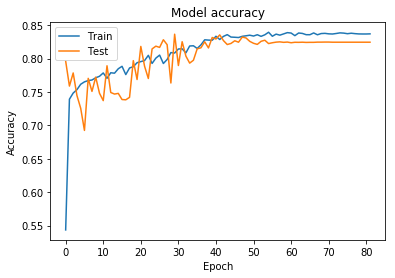

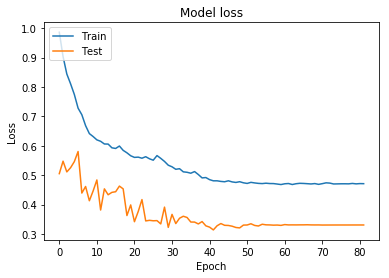

In [45]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [33]:
from collections import Counter
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())
    return {cls: float(majority / count) for cls, count in counter.items()}

In [42]:
weight_dict = get_class_weights(train_Y[~train_bg])

3.089693891191017